# 17. 프로젝트: Segmentation map으로 도로 이미지 만들기


## 목차

>   <p style="font-size:17px">Step 1. Data 준비하기</p>
    <p style="font-size:17px">Step 2. Encoder 만들기</p> 
    <p style="font-size:17px">Step 3. Decoder 만들기</p>
    <p style="font-size:17px">Step 4. U-NetGenerator 만들기</p>
    <p style="font-size:17px">Step 5. Discriminator 만들기</p>
    <p style="font-size:17px">Step 6. 학습 및 테스트하기</p>


## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  |1. 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
  |2. 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
  |3. 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## Data 준비하기
-----

In [1]:
import os

data_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/train/'
print ("number of train examples : ", len(os.listdir(data_path)))

number of train examples :  1000


* 위와 같이 1000개의 학습 이미지가 폴더안에 있는 것 을 확인할 수 있습니다. 
* 아래 코드를 이요해서 각각의 이미지들이 어떻게 생겼는지 확인해 봅니다. 임의로 6장을 선택하여 시각화합니다. 

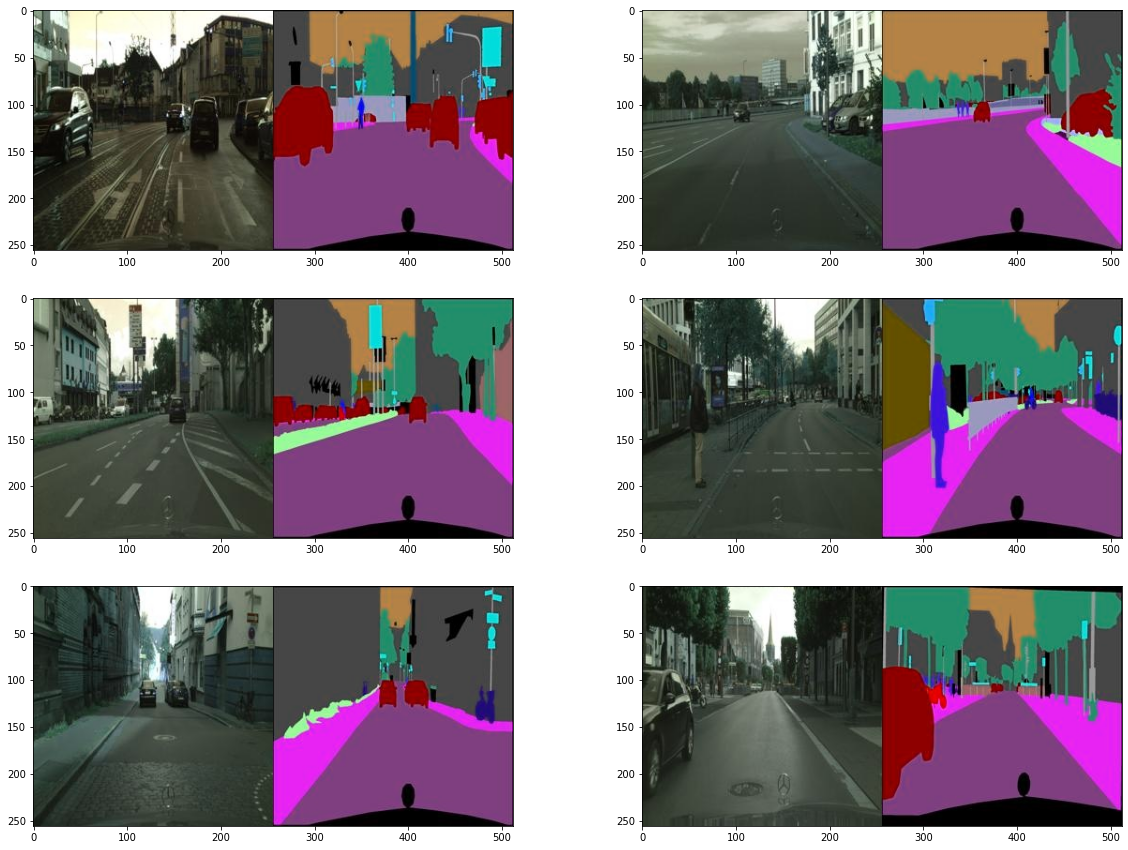

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range (1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(100)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

* 한장의 이미지에 실사와 타겟 이미지가 붙어있는 것을 확인할 수 있습니다. 한 장의 이미지 크기를 확인해 보겠습니다. 

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)의 사이즈를 갖고 있습니다. 한장의 이미지를 (256, 256, 3) 크기의 이미지 2장으로 분할하여서 사용하면 될 것 같습니다. 
* 아래의 코드로 이미지를 나누어 보겠습니다. 

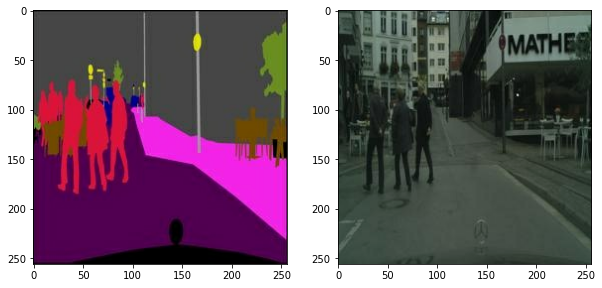

In [4]:
import tensorflow as tf

# 이미지 정규화 함수
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 시각화를 위한 이미지 복원 함수
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지 shape의 width를 1/2로 잘라서 load하는 함수
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    segment = img[:, w:, :]
    segment = tf.cast (segment, tf.float32)
    city = img[:, :w, :] 
    city = tf.cast(city, tf.float32)
    return normalize(segment), normalize(city)

f = data_path + os.listdir(data_path)[0]
segment, city = load_img(f)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1); plt.imshow(denormalize(segment))
plt.subplot(1,2,2); plt.imshow(denormalize(city))

* 위와 같이 두개의 이미지로 나뉘었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 목표입니다. 
* 학습할 수 있는 이미지가 1000개 밖에 안되기 때문에 augmentation 방법을 적용해서 다양성을 높여보겠습니다. 
    * 2가지의 방법으로 적용해보곘습니다: apply_augmentation 그리고 apply_augmentation2
        * **apply_augmentation:**
            1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
            2. (1)의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
            3. (2)의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
            4. (3)의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
            5. (4)의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
            6. (5)의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
        * **apply_augmentation2:**
            1. 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
            2. (1)의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
            3. (2)의 결과를 50% 확률로 이미지 saturation을 0.5로 조절합니다. (tf.image.adjust_saturation)
            4. (3)의 결과를 50% 확률로 이미지 brightness를 0.5로 조절합니다. (tf.image.adjust_brightness)
            5. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
           

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segment, city):
    stacked = tf.concat([segment, city], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


* apply_augmentation 함수를 적용 후, 시각화합니다. 

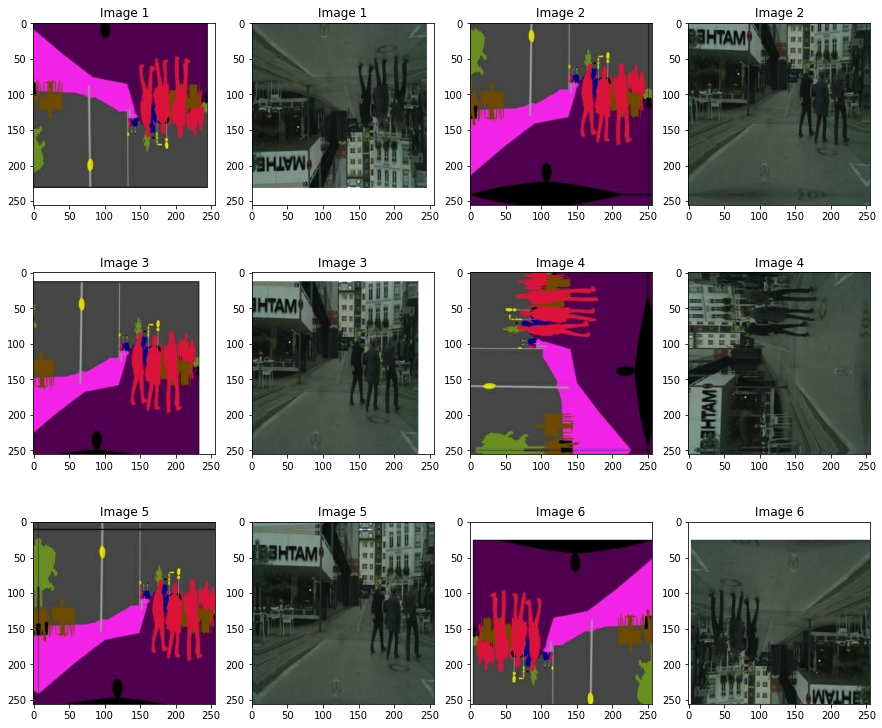

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = apply_augmentation(segment, city)
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city)); plt.title(f"Image {img_n}")
    img_n += 1

In [7]:
from tensorflow.image import adjust_brightness
from tensorflow.image import adjust_saturation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation2(segment, city):
    #stacked = tf.concat([segment, city], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded1 = tf.pad(segment, _pad, "REFLECT")
        padded2 = tf.pad(city, _pad, "REFLECT")
    else:
        padded1 = tf.pad(segment, _pad, "CONSTANT", constant_values=1.)
        padded2 = tf.pad(city, _pad, "CONSTANT", constant_values=1.)

    out1 = image.random_crop(padded1, size=[256, 256, 3])
    out2 = image.random_crop(padded2, size=[256, 256, 3])
            
    if tf.random.uniform(()) < .5:
        out1 = image.adjust_saturation(out1, 0.5)
        out2 = image.adjust_saturation(out2, 0.5)
    else:
        out1 = image.adjust_brightness(out1, 0.5)
        out2 = image.adjust_brightness(out2, 0.5)
    
    out = tf.concat([out1, out2], axis=-1)

    return out[...,:3], out[...,3:]   

print("✅")

✅


* apply_augmentation2 함수를 적용 후, 시각화합니다. 

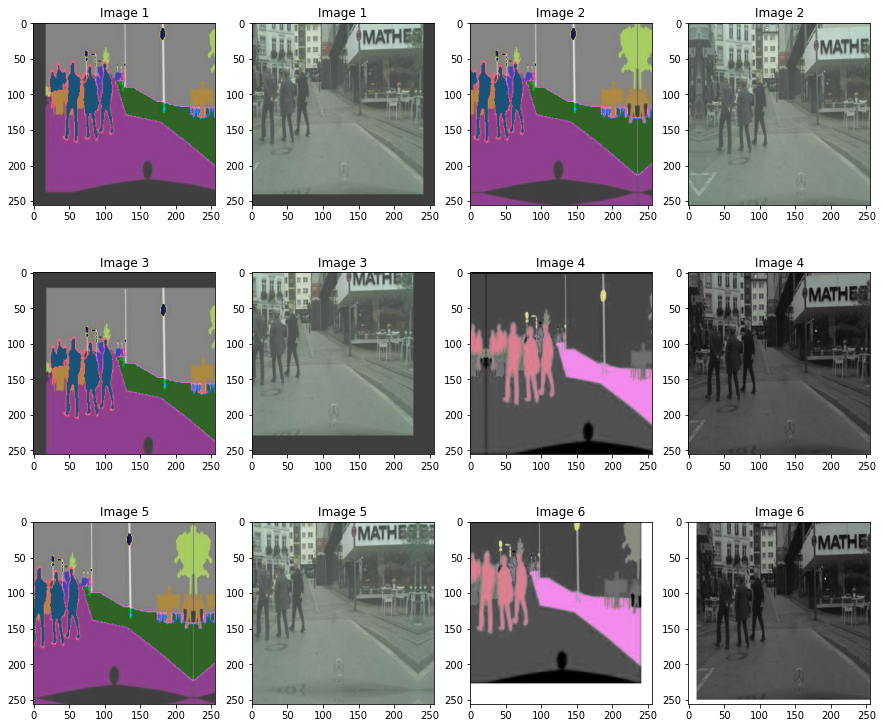

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = apply_augmentation2(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city)); plt.title(f"Image {img_n}")
    img_n += 1

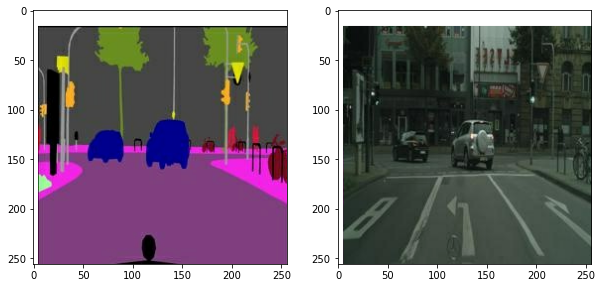

In [9]:
from tensorflow import data

def get_train(img_path):
    segment, city = load_img(img_path)
    segment, city = apply_augmentation(segment, city)
    return segment, city

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, city = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(city[0].astype(np.uint8))

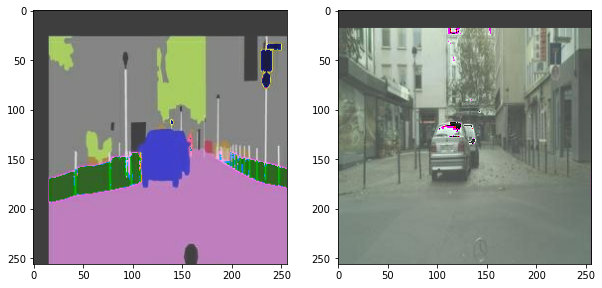

In [10]:
def get_train2(img_path):
    segment, city = load_img(img_path)
    segment, city = apply_augmentation2(segment, city)
    return segment, city

train_images2 = data.Dataset.list_files(data_path + "*.jpg")
train_images2 = train_images2.map(get_train2).shuffle(100).batch(4)

sample2 = train_images2.take(1)
sample2 = list(sample2.as_numpy_iterator())
segment, city = (sample2[0][0]+1)*127.5, (sample2[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(city[0].astype(np.uint8))

## Generator 구현하기
-----
## Encoder 만들기

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [12]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [13]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

## Decoder 만들기
-----

In [14]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


In [15]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [16]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## U-Net Generator 만들기
-----

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [18]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

## Discriminator 만들기
-----

In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [21]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

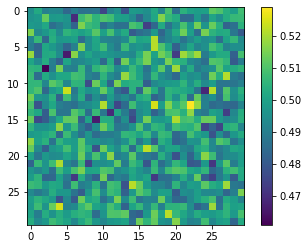

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습 및 테스트 하기
-----

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [25]:
@tf.function
def train_step(segment, real_city):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_city = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_city, training=True)
        real_disc = discriminator(segment, real_city, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_city, real_city, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


### * apply_augmentation 데이터를 학습시켜서 결과를 확인해보겠습니다. 

In [80]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

history = {'g_loss': [], 'l1_loss': [], 'd_loss': []}

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)
        
        history['g_loss'].append(g_loss.numpy())
        history['l1_loss'].append(l1_loss.numpy())
        history['d_loss'].append(d_loss.numpy())   
        
    print(f"EPOCH[{epoch}] - STEP[{i+1}] \
        \nGenerator_loss:{g_loss.numpy():.4f} \
        \nL1_loss:{l1_loss.numpy():.4f} \
        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[250]         
Generator_loss:2.2746         
L1_loss:0.1670         
Discriminator_loss:0.4109

EPOCH[2] - STEP[250]         
Generator_loss:2.0950         
L1_loss:0.1933         
Discriminator_loss:0.7606

EPOCH[3] - STEP[250]         
Generator_loss:0.8557         
L1_loss:0.2007         
Discriminator_loss:0.7893

EPOCH[4] - STEP[250]         
Generator_loss:2.0521         
L1_loss:0.2301         
Discriminator_loss:0.2435

EPOCH[5] - STEP[250]         
Generator_loss:0.8538         
L1_loss:0.1556         
Discriminator_loss:0.9212

EPOCH[6] - STEP[250]         
Generator_loss:2.1947         
L1_loss:0.1984         
Discriminator_loss:1.1025

EPOCH[7] - STEP[250]         
Generator_loss:2.0330         
L1_loss:0.1583         
Discriminator_loss:1.4861

EPOCH[8] - STEP[250]         
Generator_loss:1.9379         
L1_loss:0.1801         
Discriminator_loss:0.3470

EPOCH[9] - STEP[250]         
Generator_loss:2.6004         
L1_loss:0.1923         
Discriminator_loss:

In [81]:
val_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/val/'
print ("number of val examples : ", len(os.listdir(val_path)))

number of val examples :  5


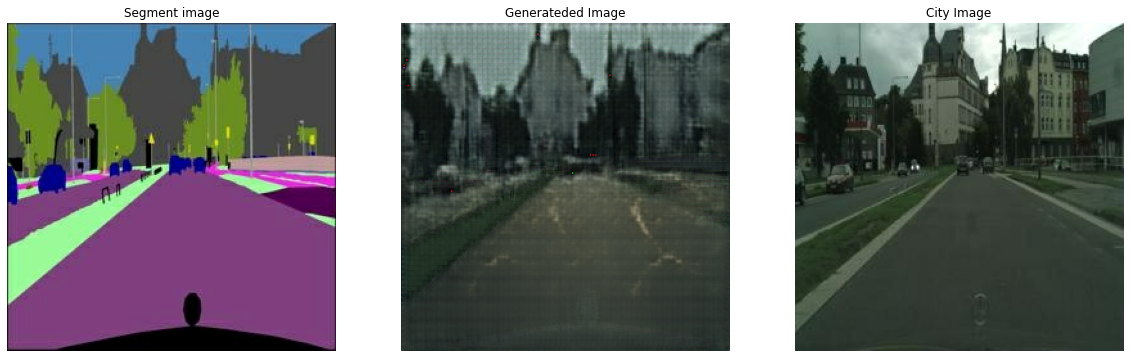

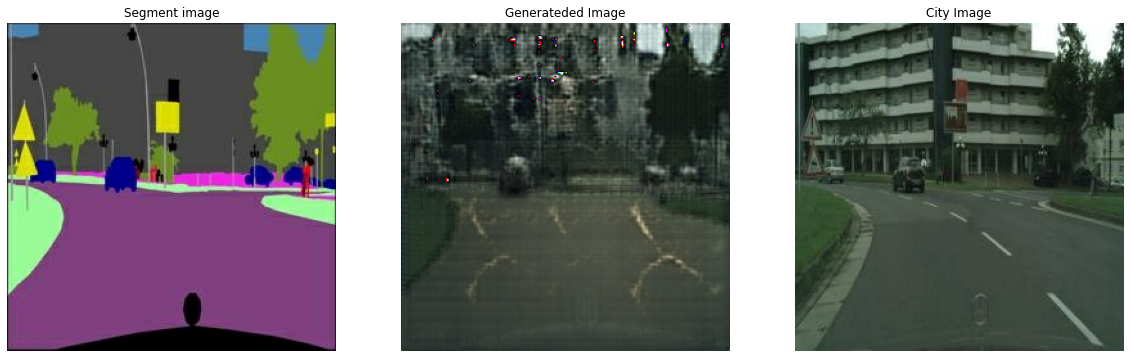

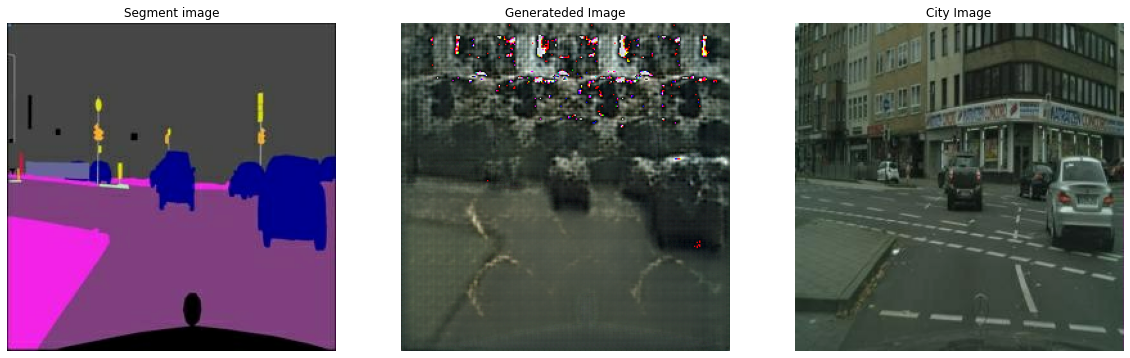

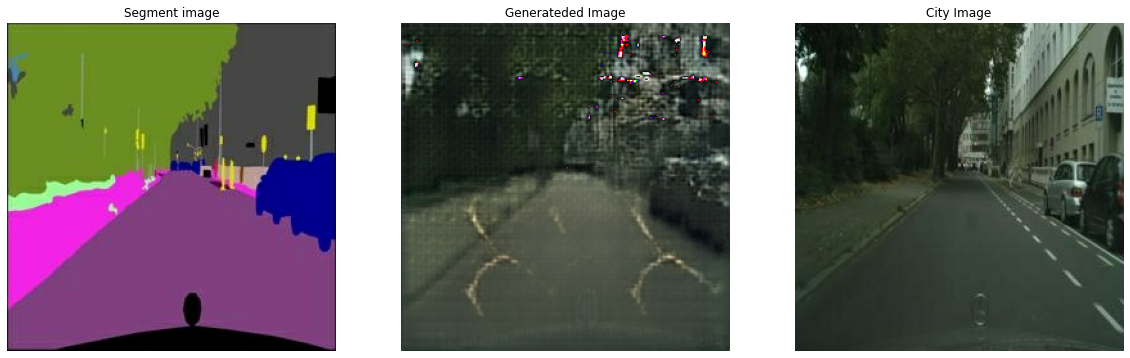

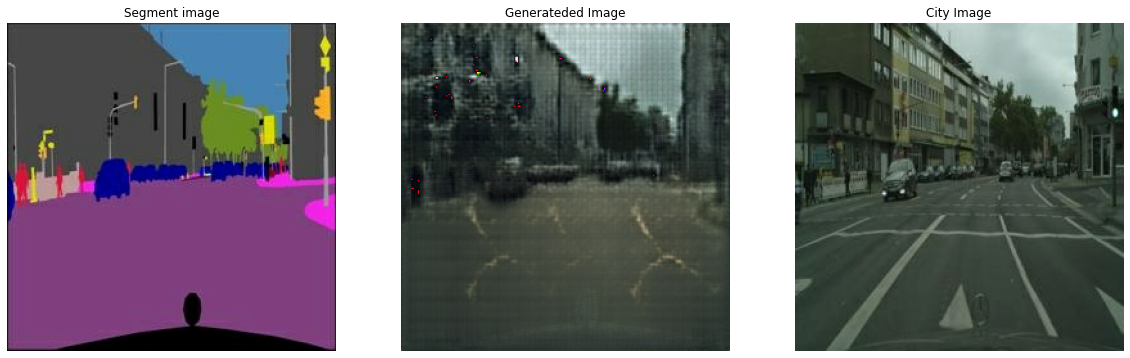

In [90]:
test_ind = 0

for i in range (len(os.listdir(val_path))):
    f = data_path + os.listdir(val_path)[i]
    segment, city = load_img(f)

    pred = generator(tf.expand_dims(segment, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Segment image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Generateded Image'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('City Image'); plt.axis('off')

### * apply_augmentation2 데이터를 학습시켜서 결과를 확인해보겠습니다. 

In [26]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

history2 = {'g_loss': [], 'l1_loss': [], 'd_loss': []}

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images2):
        g_loss, l1_loss, d_loss = train_step(segment, city)
        
        history2['g_loss'].append(g_loss.numpy())
        history2['l1_loss'].append(l1_loss.numpy())
        history2['d_loss'].append(d_loss.numpy())   
        
    print(f"EPOCH[{epoch}] - STEP[{i+1}] \
        \nGenerator_loss:{g_loss.numpy():.4f} \
        \nL1_loss:{l1_loss.numpy():.4f} \
        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[250]         
Generator_loss:2.7106         
L1_loss:0.3386         
Discriminator_loss:0.2588

EPOCH[2] - STEP[250]         
Generator_loss:2.1495         
L1_loss:0.2920         
Discriminator_loss:0.5718

EPOCH[3] - STEP[250]         
Generator_loss:2.8460         
L1_loss:0.2826         
Discriminator_loss:0.3165

EPOCH[4] - STEP[250]         
Generator_loss:2.1837         
L1_loss:0.2995         
Discriminator_loss:0.2345

EPOCH[5] - STEP[250]         
Generator_loss:1.5864         
L1_loss:0.2892         
Discriminator_loss:0.3607

EPOCH[6] - STEP[250]         
Generator_loss:1.9725         
L1_loss:0.2722         
Discriminator_loss:0.5185

EPOCH[7] - STEP[250]         
Generator_loss:1.1461         
L1_loss:0.2622         
Discriminator_loss:0.7156

EPOCH[8] - STEP[250]         
Generator_loss:2.1273         
L1_loss:0.4115         
Discriminator_loss:0.2694

EPOCH[9] - STEP[250]         
Generator_loss:2.3660         
L1_loss:0.3232         
Discriminator_loss:

In [27]:
val_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/val/'
print ("number of val examples : ", len(os.listdir(val_path)))

number of val examples :  5


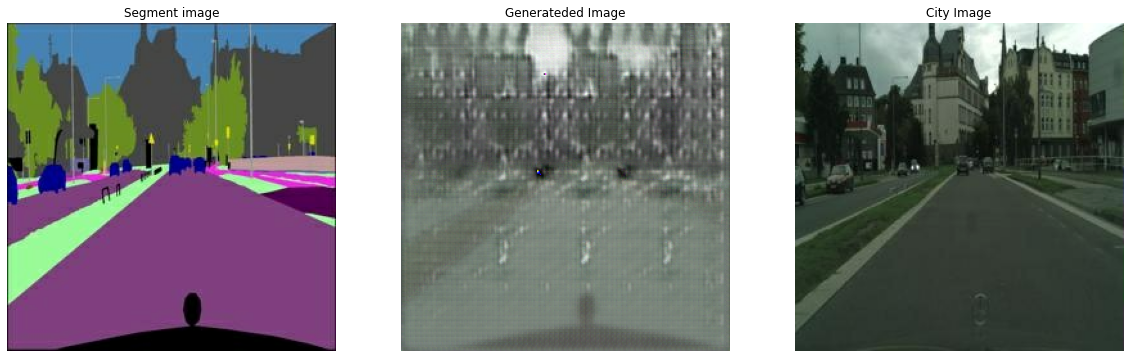

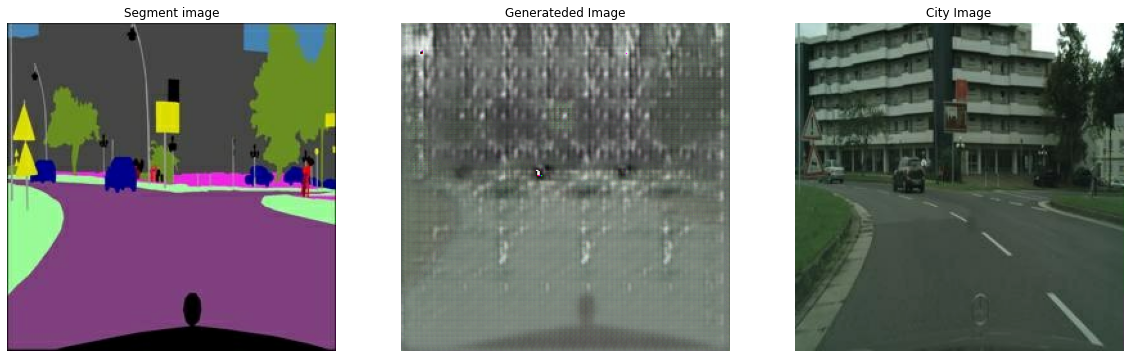

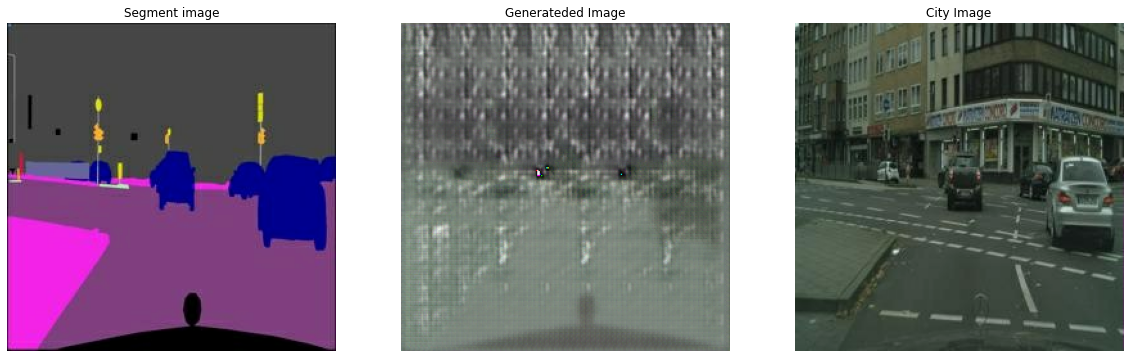

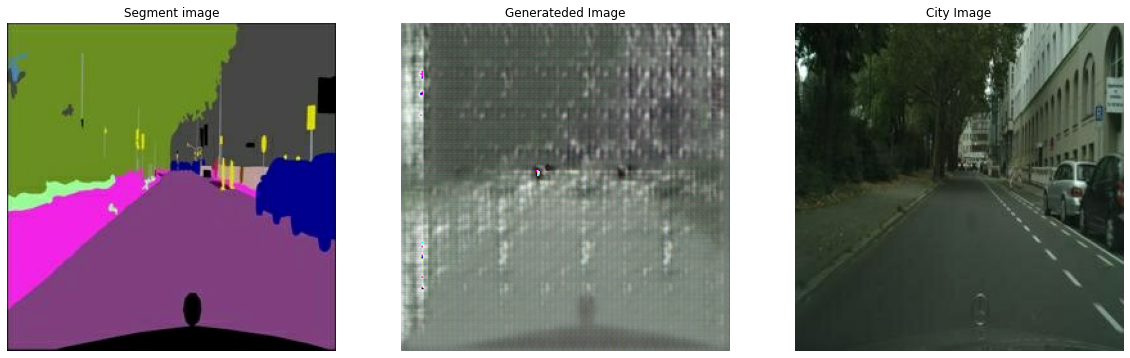

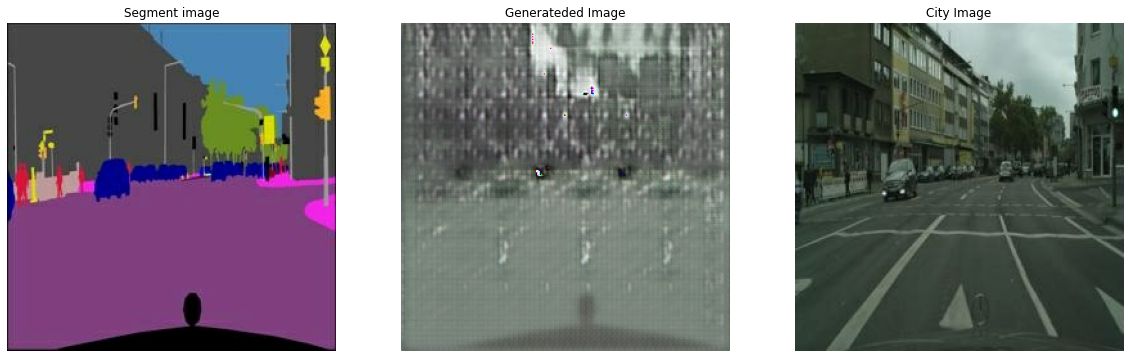

In [28]:
test_ind = 0

for i in range (len(os.listdir(val_path))):
    f = data_path + os.listdir(val_path)[i]
    segment, city = load_img(f)

    pred = generator(tf.expand_dims(segment, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Segment image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Generateded Image'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('City Image'); plt.axis('off')

* 2가지의 방법으로 적용해보곘습니다: apply_augmentation 그리고 apply_augmentation2
    * **apply_augmentation:**
        1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
        2. (1)의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
        3. (2)의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
        4. (3)의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
        5. (4)의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
        6. (5)의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    * **apply_augmentation2:**
        1. 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
        2. (1)의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
        3. (2)의 결과를 50% 확률로 이미지 saturation을 0.5로 조절합니다. (tf.image.adjust_saturation)
        4. (3)의 결과를 50% 확률로 이미지 brightness를 0.5로 조절합니다. (tf.image.adjust_brightness)
        5. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.


* 두개의 데이터셋을 활용해서 학습을 EPOCH=20으로 진행했을 때, **`apply_augmentation`** 으로 학습한 결과가 validation 이미지 상으로는 더 좋아보입니다. 
    * 다른 말로는 물리적인 augmentation을 적용한 데이터셋 학습 결과가 채색(?) augmentation을 적용한 데이터셋 학습 결과보다 더 좋았다고 판단할 수 있을 것 같습니다. 